# Import Libraries

In [23]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import cv2 
import os 
from os.path import join
from random import shuffle 
from tqdm import tqdm 
from PIL import Image

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.linear_model import SGDClassifier



import warnings
import random
warnings.filterwarnings('ignore')


In [2]:
! ls ../data/raw/real_vs_fake/real-vs-fake/

test  train  valid


In [3]:
train_real = r'../data/raw/real_vs_fake/real-vs-fake/train/real/'
train_fake = r'../data/raw/real_vs_fake/real-vs-fake/train/fake/'

val_real = r'../data/raw/real_vs_fake/real-vs-fake/valid/real/'
val_fake = r'../data/raw/real_vs_fake/real-vs-fake/valid/fake/'

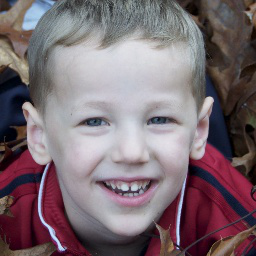

In [4]:
Image.open(join(train_real,random.choice(os.listdir(train_real))))

## Read train images

In [73]:
def get_data(real_data_path, fake_data_path, samp_size = 10, flatten = True, normalize = True,  image_size = 256):
    '''
    Method to collect the data from real and fake folders an join to get train data
    '''
    data_real, real_labels = [], []
    data_fake, fake_labels = [], []
    
    if samp_size == -1:
        real_files = os.listdir(real_data_path)
        fake_files = os.listdir(fake_data_path)
    else:
        real_files = os.listdir(real_data_path)[:samp_size]
        fake_files = os.listdir(fake_data_path)[:samp_size]
        
    for image in tqdm(real_files): 
        path = os.path.join(real_data_path, image)
        img1 = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
        img1 = cv2.resize(img1, (image_size, image_size))
        data_real.append(img1)
        real_labels.append(1)
        
    for image in tqdm(fake_files): 
        path = os.path.join(fake_data_path, image)
        img2 = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
        img2 = cv2.resize(img2, (image_size, image_size))
        data_fake.append(img2)
        fake_labels.append(0)
        
    data= np.concatenate((np.asarray(data_real),np.asarray(data_fake)),axis=0)
    if flatten:
        data = data.reshape(data.shape[0], data.shape[1] * data.shape[2])
        if normalize:
            data = (data-np.min(data))/(np.max(data)-np.min(data))
            
    label_data = np.concatenate((np.asarray(real_labels),np.asarray(fake_labels)),axis=0)
    
    data, label_data = shuffle(data, label_data, random_state=0)
    return data, label_data

In [74]:
X_train, y_train = get_data(train_real, train_fake, 2000, True, True, 128)
X_val, y_val = get_data(val_real, val_fake, 1000, True, True, 128)

print(f'Shape of train data {X_train.shape}, shape of train labels {y_train.shape}')
print(f'Shape of train data {X_val.shape}, shape of train labels {y_val.shape}')

100%|██████████| 1000/1000 [00:02<00:00, 483.37it/s]


Shape of train data (4000, 16384), shape of train labels (4000,)
Shape of train data (2000, 16384), shape of train labels (2000,)


In [75]:
# X_train

## Logistic Regression baseline

In [76]:
# grid={"C":np.logspace(-3,3,7),"penalty":["l2"],"max_iter":[100]}

# logistic_regression=LogisticRegression(random_state=42)
# log_reg_cv=GridSearchCV(logistic_regression,grid,cv=10)

# log_reg_cv.fit(X_train.T, y_train.T)

In [77]:
# print("best hyperparameters: ", log_reg_cv.best_params_)
# print("accuracy: ", log_reg_cv.best_score_)

In [79]:
log_reg= LogisticRegression(fit_intercept=True,
                        max_iter=100,
                        verbose = True,
                        n_jobs = 10,
                        C = 100)
log_reg.fit(X_train,y_train)

print("test accuracy: {} ".format(log_reg.score(X_val, y_val)))
print("train accuracy: {} ".format(log_reg.score(X_train, y_train)))

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:  3.1min finished


test accuracy: 0.724 
train accuracy: 0.922 


In [80]:
y_pred = log_reg.predict_proba(X_val)
# cm = metrics.confusion_matrix(y_val, y_pred)
# cm
y_pred

array([[2.59674979e-01, 7.40325021e-01],
       [9.92060792e-01, 7.93920788e-03],
       [9.32699536e-01, 6.73004637e-02],
       ...,
       [9.99994361e-01, 5.63916053e-06],
       [3.01050209e-03, 9.96989498e-01],
       [9.75414645e-01, 2.45853545e-02]])

In [81]:
y_pred = log_reg.predict(X_val)
cm = metrics.confusion_matrix(y_val, y_pred)
cm

array([[760, 240],
       [312, 688]])

In [82]:
# np.max(y_pred)

In [83]:
print('Percentage correct: ', 100*np.sum(y_pred == y_val)/len(y_val))

Percentage correct:  72.4


In [84]:
sgd_clf = SGDClassifier(random_state=42, max_iter=5000, tol=1e-5, loss = 'hinge', penalty = 'l2')
sgd_clf.fit(X_train, y_train)

SGDClassifier(max_iter=5000, random_state=42, tol=1e-05)

In [88]:
y_pred = sgd_clf.predict(X_val)
cm = metrics.confusion_matrix(y_val, y_pred)
cm
# y_pred[:10]

array([[950,  50],
       [694, 306]])

In [89]:
print('Percentage correct: ', 100*np.sum(y_pred == y_val)/len(y_val))

Percentage correct:  62.8


In [90]:
X_val, y_val

(array([[0.35686275, 0.32156863, 0.29019608, ..., 0.37647059, 0.50980392,
         0.65490196],
        [0.36470588, 0.31372549, 0.30980392, ..., 0.90196078, 0.89411765,
         0.87058824],
        [0.49803922, 0.4627451 , 0.45490196, ..., 0.49803922, 0.49803922,
         0.50588235],
        ...,
        [0.42745098, 0.38039216, 0.42352941, ..., 0.2627451 , 0.24313725,
         0.21568627],
        [0.2627451 , 0.25882353, 0.2627451 , ..., 0.37647059, 0.43529412,
         0.55686275],
        [0.8       , 0.8       , 0.80392157, ..., 0.05882353, 0.05882353,
         0.0745098 ]]),
 array([1, 0, 0, ..., 0, 1, 1]))